In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
#import beer
import matplotlib
from scipy.special import erfinv, erf
from scipy.stats import norm

In [3]:
def read_list(fid):
    dict_utt = {}
    with open(fid, 'r') as f:
        for line in f:
            tokens = line.strip().split()
            utt = tokens[0]
            dict_utt[utt] = 0
    return dict_utt

def read_text(fid):
    dict_text = {}
    with open(fid, 'r') as f:
        for line in f:
            tokens = line.strip().split()
            utt = tokens.pop(0)
            dict_text[utt] = tokens
    return dict_text

def find_equal(x, y):
    dis = []
    for i, m in enumerate(x):
        dis.append(abs(m - y[i]))
    minum = min(dis)
    return(y[dis.index(minum)])

def read_fn_fp(fid):
    fn = []
    fp = []
    thres = []
    with open(fid, 'r') as f:
        for line in f:
            tokens = line.strip().split()
            thres.append(tokens[1])
            fn.append(tokens[3])
            fp.append(tokens[5])
    fn = np.array([float(i) for i in fn])
    fp = np.array([float(i) for i in fp])
    
    #fp = np.log10(fp) + 1e-10
    #fn = np.log10(fn) + 1e-10
    fp[np.where(fp == 0)] += 1e-3
    fp[np.where(fp == 1)] -= 1e-3
    fn[np.where(fn == 0)] += 1e-3
    fn[np.where(fn == 1)] -= 1e-3
    eer = fp[np.nanargmin(np.abs(fn - fp))]
    fp = compute_probit(fp)
    fn = compute_probit(fn)
    return thres, fn, fp, eer


def get_var(llhs_npz_file, uttids):
    var_arr = []
    for k in uttids:
        var_arr.append(llhs_npz_file[k].var())
    return np.array(var_arr, dtype=float)

def get_diff_var(ali_llhs_npz, hyp_llhs_npz, uttids):
    var_arr = []
    for k in uttids:
        var_arr.append((ali_llhs_npz[k] - hyp_llhs_npz[k]).var())
    return np.array(var_arr, dtype=float)

def compute_probit(p):
    return np.sqrt(2) * erfinv(2 * p - 1)

def compute_phi(z):
    return .5 * (1 + erf(z/np.sqrt(2)))

def create_ticks():
    tick = np.array([.01, .02, .05, .1, .2, .5, .8])
    locs = compute_probit(tick)
    
    return locs, tick * 100
    
    

### Plot DET

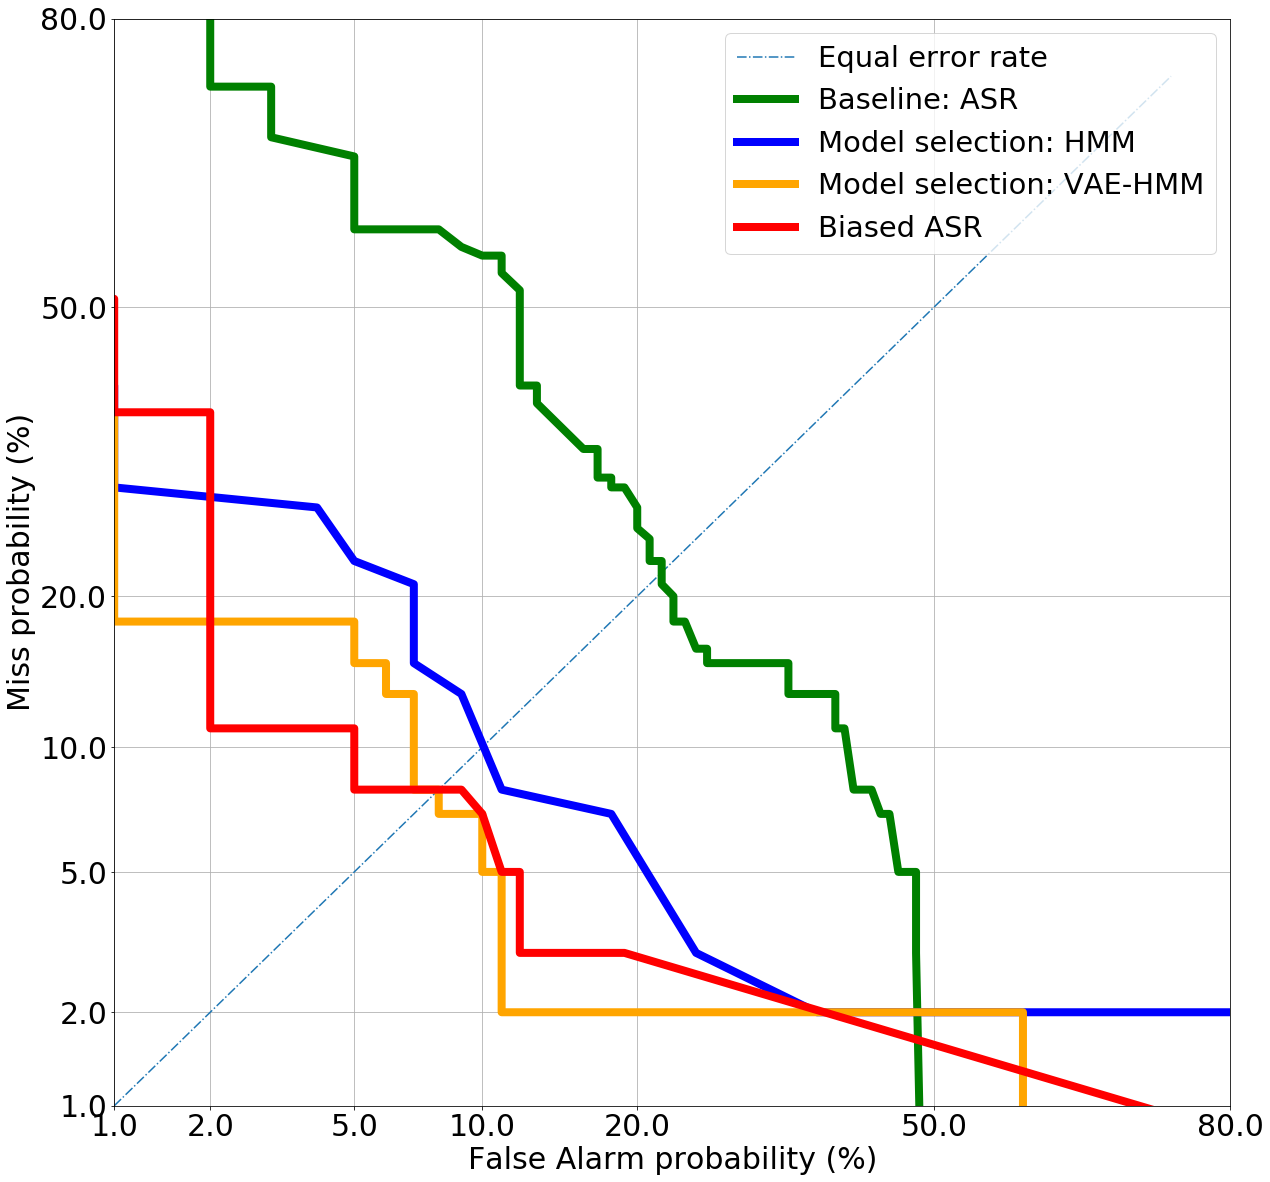

In [6]:
dataname = 'test_all_ser_30_wer_6'

thres_hmm, fn_hmm, fp_hmm, eer_hmm = read_fn_fp('./joint_per_detection/beer_hmm_gmm_only/' + 
                                       dataname + '/det_frame_llhs.txt')
thres_vae, fn_vae, fp_vae, eer_vae = read_fn_fp('./joint_per_detection/beer_hmm_vae_only/' + 
                                       dataname + '/det_frame_llhs.txt')
thres_per, fn_per, fp_per, eer_per = read_fn_fp('./joint_per_detection/kaldi_per_only/' + 
                                       dataname + '/det_per.txt')
thres_cleanup, fn_cleanup, fp_cleanup, eer_cleanup = read_fn_fp('./joint_per_detection/kaldi_cleanup_only/'
                                                   + dataname + '/det_per.txt')
thres_hmm_ali_var, fn_hmm_ali_var, fp_hmm_ali_var, eer_hmm_ali_var = read_fn_fp('./joint_per_detection/beer_hmm_gmm_only/' + 
                                                              dataname + '/det_ali_var.txt')
thres_vae_ali_var, fn_vae_ali_var, fp_vae_ali_var, eer_vae_ali_var = read_fn_fp('./joint_per_detection/beer_hmm_vae_only/' + 
                                                              dataname + '/det_ali_var.txt')
x = np.arange(compute_probit(1e-2), compute_probit(.8))
y = x

hmm_equal = find_equal(fn_hmm, fp_hmm)
vae_equal = find_equal(fn_vae, fp_vae)
#per_equal = find_equal(fn_per, fp_per)
cleanup_equal = find_equal(fn_cleanup, fp_cleanup)


# Plot det
plt.figure(figsize=(20, 20))
plt.plot(x, y, '-.')
plt.plot(fp_per, fn_per, color='g', linewidth=8, linestyle='-')
#plt.plot(fp_hmm_ali_var, fn_hmm_ali_var, color='m', linewidth=8, linestyle='-')
#plt.plot(fp_vae_ali_var, fn_vae_ali_var, color='c', linewidth=8, linestyle='-')
plt.plot(fp_hmm, fn_hmm, color='b', linewidth=8, linestyle='-')
plt.plot(fp_vae, fn_vae, color='orange', linewidth=8, linestyle='-')
plt.plot(fp_cleanup, fn_cleanup, color='r', linewidth=8, linestyle='-')
plt.grid()

# Label equal error rate
#plt.vlines(x=hmm_equal, ymin=0, ymax=hmm_equal, color='r', linestyles='dotted')
#plt.vlines(x=vae_equal, ymin=0, ymax=vae_equal, color='b', linestyles='dotted')
#plt.vlines(x=per_equal, ymin=0, ymax=per_equal, color='g', linestyles='dotted')
#plt.vlines(x=cleanup_equal, ymin=0, ymax=cleanup_equal, colors='orange', linestyles='dotted')
#ax = plt.gca()
#ax.text(hmm_equal, 0, '{0:.2f}'.format(hmm_equal), fontsize=10, color='r')
#ax.text(vae_equal, 0, '{0:.2f}'.format(vae_equal), fontsize=10, color='b')
#ax.text(per_equal, 0, '{0:.2f}'.format(per_equal), fontsize=10, color='g')
#ax.text(cleanup_equal, 0, '{0:.2f}'.format(cleanup_equal), fontsize=10, color='orange')

#plt.title(f'DET: Detection of wrong transcription for {dataname}', fontsize=15)
plt.xlabel('False Alarm probability (%)', fontsize=30)
plt.ylabel('Miss probability (%)', fontsize=30)
plt.legend(['Equal error rate', 
            f'Baseline: ASR', 
            f'Model selection: HMM',
            f'Model selection: VAE-HMM',
            f'Biased ASR',], 
            loc='upper right',
            fontsize=29)

plt.xticks(create_ticks()[0], create_ticks()[1], fontsize=30)
plt.yticks(create_ticks()[0], create_ticks()[1], fontsize=30)
plt.xlim([compute_probit(1e-2), compute_probit(.8)])
plt.ylim([compute_probit(1e-2), compute_probit(.8)])
#plt.yscale('log')
#plt.xscale('log')
plt.savefig('./joint_per_detection/pics/det_comparison_' + dataname + '.png')
plt.show()

### Plot ROC

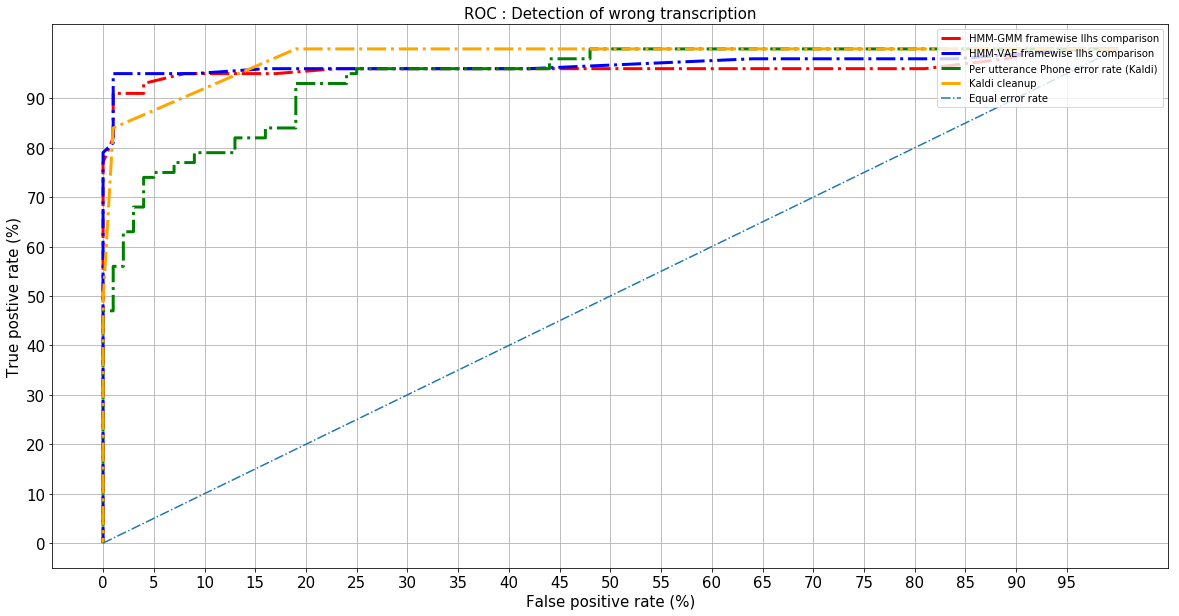

In [9]:
#thres_hmm, tp_hmm, fp_hmm = read_fn_fp('./icassp_task/hmm-gmm/test_wrong_trans_95/roc_frame_llhs.txt')
#thres_vae, tp_vae, fp_vae = read_fn_fp('./icassp_task/vae_hmm_2/test_wrong_trans_95/roc_frame_llhs.txt')
#thres_per, tp_per, fp_per = read_fn_fp('./icassp_task/vae_hmm_2/test_wrong_trans_95/roc_per.txt')

dataname = 'test_del_ser_30_wer_6'

thres_hmm, tp_hmm, fp_hmm = read_fn_fp('./joint_per_detection/beer_hmm_gmm_only/' + 
                                       dataname + '/roc_frame_llhs.txt')
thres_vae, tp_vae, fp_vae = read_fn_fp('./joint_per_detection/beer_hmm_vae_only/' + 
                                       dataname + '/roc_frame_llhs.txt')
thres_per, tp_per, fp_per = read_fn_fp('./joint_per_detection/kaldi_per_only/' + 
                                       dataname + '/roc_per.txt')
thres_cleanup, tp_cleanup, fp_cleanup = read_fn_fp('./joint_per_detection/kaldi_cleanup_only/'
                                                   + dataname + '/roc_per.txt')

x = np.arange(0, 100)
y = x

plt.figure(figsize=(20, 10))

plt.plot(fp_hmm, tp_hmm, color='r', linewidth=3, linestyle='-.')
plt.plot(fp_vae, tp_vae, color='b', linewidth=3, linestyle='-.')
plt.plot(fp_per, tp_per, color='g', linewidth=3, linestyle='-.')
plt.plot(fp_cleanup, tp_cleanup, color='orange', linewidth=3, linestyle='-.')
plt.plot(x, y, '-.')
plt.grid()
plt.title('ROC : Detection of wrong transcription', fontsize=15)
plt.xlabel('False positive rate (%)', fontsize=15)
plt.ylabel('True postive rate (%)', fontsize=15)
plt.legend(['HMM-GMM framewise llhs comparison', 'HMM-VAE framewise llhs comparison','Per utterance Phone error rate (Kaldi)', 'Kaldi cleanup', 'Equal error rate'], loc='upper right')
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 100, 10))
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
#plt.savefig('./pics/roc_methods_comparison_95_wrong_vae_2.jpg')
plt.show()

### Details in utterance

In [12]:
dataname = 'test_all_ser_30_wer_6'

ali_hmm = np.load('./joint_per_detection/beer_hmm_gmm_only/' + 
                    dataname + '/ali_frame_llhs.npz')
ali_vae = np.load('./joint_per_detection/beer_hmm_vae_only/' + 
                    dataname + '/ali_frame_llhs.npz')
hyp_hmm = np.load('./joint_per_detection/beer_hmm_gmm_only/' + 
                    dataname + '/hyp_frame_llhs.npz')
hyp_vae = np.load('./joint_per_detection/beer_hmm_vae_only/' + 
                    dataname + '/hyp_frame_llhs.npz')

ali_hmm_true = np.load('./joint_per_detection/beer_hmm_gmm_only/test/ali_frame_llhs.npz')
ali_vae_true = np.load('./joint_per_detection/beer_hmm_vae_only/test/ali_frame_llhs.npz')
hyp_hmm_true = np.load('./joint_per_detection/beer_hmm_gmm_only/test/hyp_frame_llhs.npz')
hyp_vae_true = np.load('./joint_per_detection/beer_hmm_vae_only/test/hyp_frame_llhs.npz')

true_uttids = read_list('./data/' + dataname + '/true_uttids')
false_uttids = read_list('./data/' + dataname + '/false_uttids')

In [13]:
k_true = 'FELC0_SI2016'
k_false = 'MBPM0_SI1577'
k = 'MBPM0_SI1577'

In [14]:
ali_vae_true_vars = get_var(ali_vae_true, true_uttids)
ali_vae_false_vars = get_var(ali_vae, false_uttids)
diff_vae_true_vars = get_diff_var(ali_vae_true, hyp_vae_true, true_uttids)
diff_vae_false_vars = get_diff_var(ali_vae, hyp_vae, false_uttids)

#diff_vae_true_vars_norm = get_diff_var(ali_vae_true, hyp_vae_true, true_uttids)
#diff_vae_false_vars_norm = get_diff_var(ali_vae, hyp_vae, false_uttids)


In [15]:
val_diff_true = ali_vae_true[k] - hyp_vae_true[k]
val_diff_false = ali_vae[k] - hyp_vae[k]

### Plot VAE vars histogram

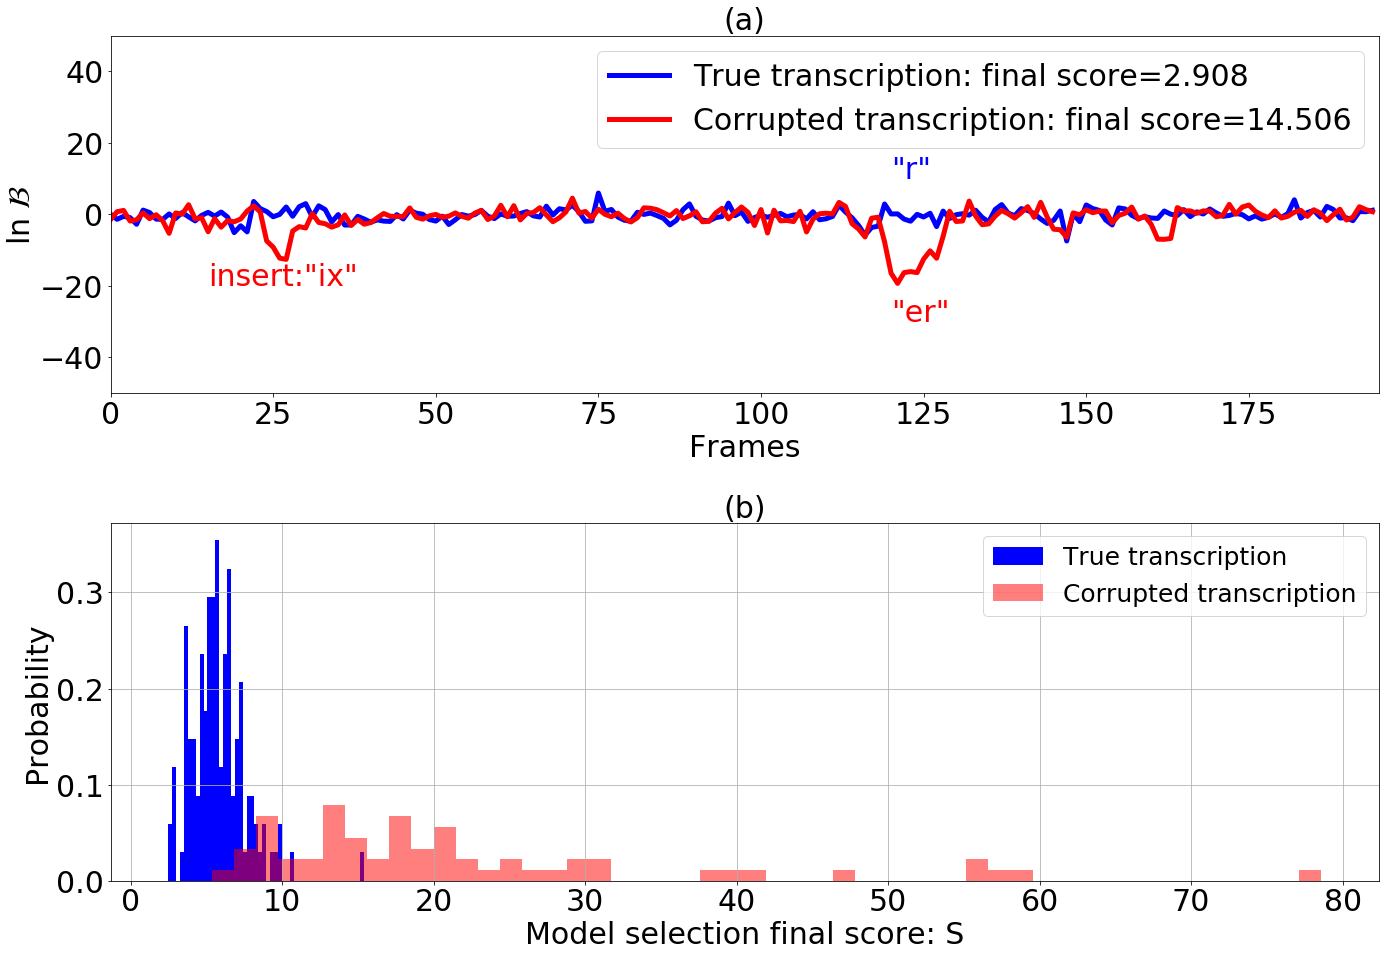

In [43]:
matplotlib.rcParams.update({'font.size': 30})

fig, arr = plt.subplots(2, 1, figsize=(20, 14))
# Align llhs var only
abs_true = ali_vae_true_vars
abs_false = ali_vae_false_vars
#abs_true -= abs_true.mean()
#abs_false -= abs_false.mean()
#abs_true /= abs_true.std()
#abs_false /= abs_false.std()


diff_true = diff_vae_true_vars
diff_false = diff_vae_false_vars

#diff_true -= diff_true.mean()
#diff_false -= diff_false.mean()
#diff_true /= diff_true.std()
#diff_false /= diff_false.std()
#_, _, _ = arr[0].hist(abs_true, bins=50, density=True, color='b', alpha=.5)
#_, _, _ = arr[0].hist(abs_false, bins=50, density=True, color='r', alpha=.5)
#arr[0].legend(['True transcription', 
#               'Mismatched transcription'], 
#               fontsize=25,
#               loc='upper right')
##arr[0].set_xlim([0, len(val_true)])
##arr[0].set_ylim([-200, 200])
#arr[0].set_title('(a)', fontsize=25)
#arr[0].set_ylabel('Variance')
#arr[0].grid()



arr[0].plot(val_diff_true, linewidth=5, color='b', linestyle='-')
arr[0].text(15, -20, 'insert:\"ix\"', color='r')
arr[0].text(120, 10, '\"r\"', color='b')
arr[0].text(120, -30, '\"er\"', color='r')

arr[0].plot(val_diff_false, linewidth=5, color='r', linestyle='-')
var_diff_true = '{0:.3f}'.format(val_diff_true.var())
var_diff_false = '{0:.3f}'.format(val_diff_false.var())
arr[0].legend([f'True transcription: final score={var_diff_true}', 
               f'Corrupted transcription: final score={var_diff_false}'], 
               fontsize=30,
               loc='upper right')
arr[0].set_ylim([-50, 50])
arr[0].set_xlim([0, len(val_diff_true)])
arr[0].set_ylabel(r'ln $\mathcal{B}$')
arr[0].set_title('(a)',
             fontsize=30)
arr[0].set_xlabel('Frames', fontsize=30)


_, _, _ = arr[1].hist(diff_true, bins=50, density=True, color='b')
_, _, _ = arr[1].hist(diff_false, bins=50, density=True, color='r', alpha=.5)
arr[1].legend(['True transcription', 
               'Corrupted transcription'], 
               fontsize=25,
               loc='upper right')
#arr[0].set_xlim([0, len(val_true)])
#arr[0].set_ylim([0, 0.1])
arr[1].set_title('(b)', fontsize=30)
arr[1].set_xlabel('Model selection final score: S', fontsize=30)
arr[1].set_ylabel('Probability', fontsize=30)
arr[1].grid()
plt.tight_layout()

plt.savefig('./joint_per_detection/pics/details/var_distribution.png')
plt.show()


$\mathcal{B}$

### Plot VAE llhs details

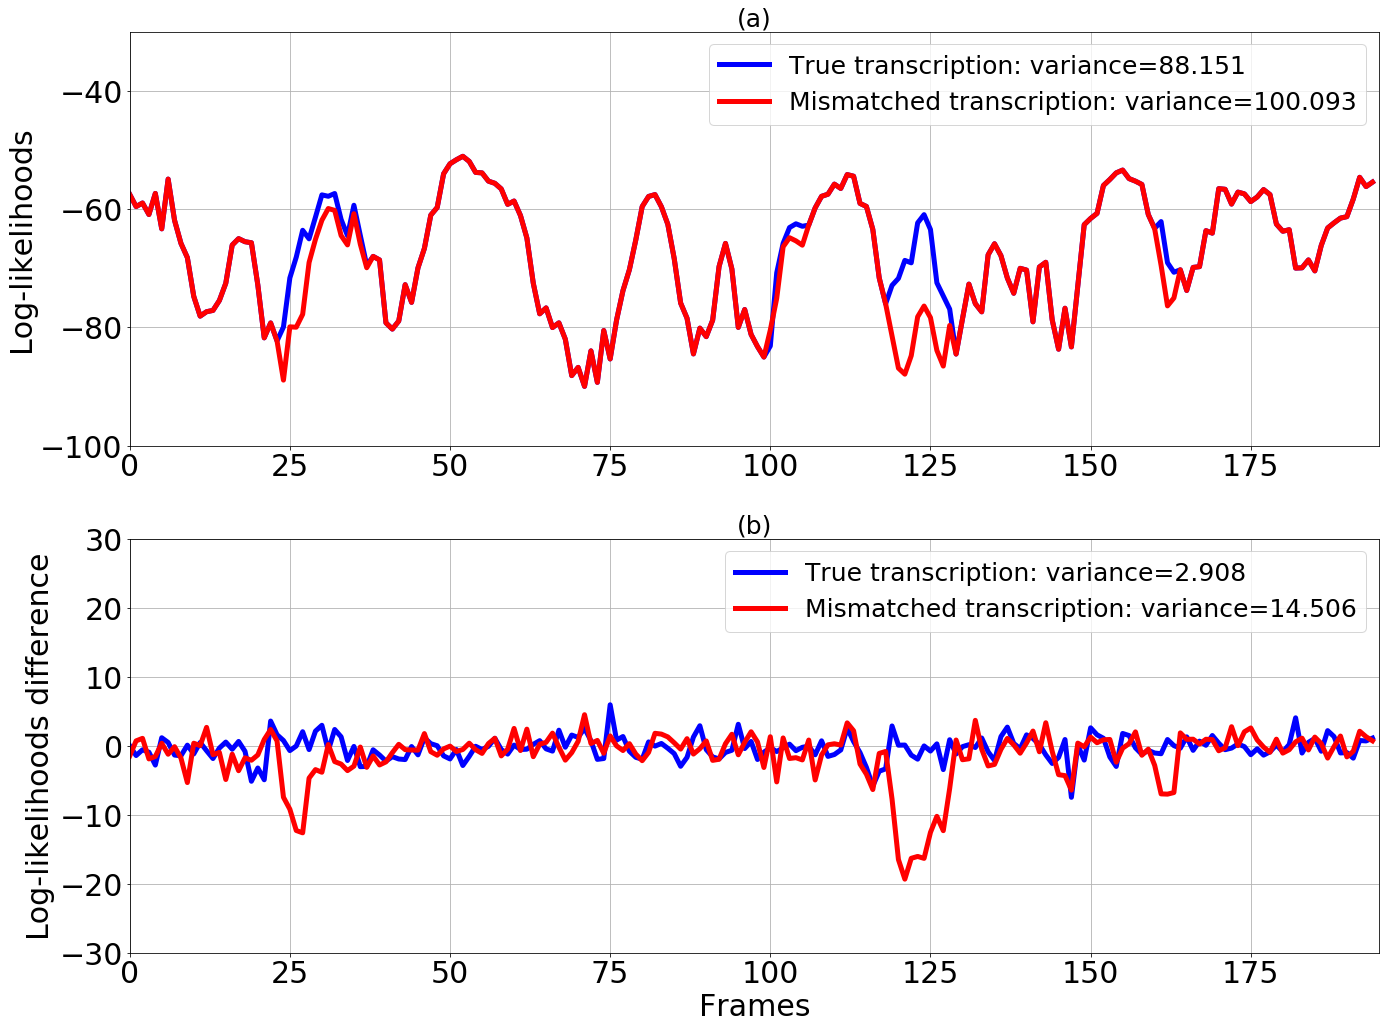

In [336]:
val_diff_true = ali_vae_true[k] - hyp_vae_true[k]
val_diff_false = ali_vae[k] - hyp_vae[k]

val_true = ali_vae_true[k]
val_false = ali_vae[k]

fname = './joint_per_detection/pics/details/vae_example.png'
matplotlib.rcParams.update({'font.size': 30})

fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(211)
ax1.plot(val_true, linewidth=5, color='b', linestyle='-')
ax1.plot(val_false, linewidth=5, color='r', linestyle='-')
var_true = '{0:.3f}'.format(val_true.var())
var_false = '{0:.3f}'.format(val_false.var())
ax1.legend([f'True transcription: variance={var_true}', 
               f'Mismatched transcription: variance={var_false}'], 
               fontsize=25,
               loc='upper right')
ax1.set_xlim([0, len(val_true)])
ax1.set_ylim([-100, -30])
ax1.set_title('(a)', fontsize=25)
ax1.set_ylabel('Log-likelihoods')
ax1.grid()

ax2 = fig.add_subplot(212)
ax2.plot(val_diff_true, linewidth=5, color='b', linestyle='-')
ax2.plot(val_diff_false, linewidth=5, color='r', linestyle='-')
var_diff_true = '{0:.3f}'.format(val_diff_true.var())
var_diff_false = '{0:.3f}'.format(val_diff_false.var())
ax2.legend([f'True transcription: variance={var_diff_true}', 
               f'Mismatched transcription: variance={var_diff_false}'], 
               fontsize=25,
               loc='upper right')
ax2.set_ylim([-30, 30])
ax2.set_xlim([0, len(val_diff_true)])
ax2.set_ylabel('Log-likelihoods difference')
ax2.set_title('(b)',
             fontsize=25)
plt.xlabel('Frames')
#plt.text(-30, 70, 'Difference between two log-likelihoods', rotation='vertical')
ax2.grid()
plt.tight_layout()
plt.savefig(fname)
plt.show()

In [268]:
fp_vae[:100]

array([ 3.09023231,  3.09023231,  3.09023231,  3.09023231,  3.09023231,
        3.09023231,  3.09023231,  3.09023231,  3.09023231,  3.09023231,
        3.09023231,  3.09023231,  3.09023231,  3.09023231,  3.09023231,
        3.09023231,  3.09023231,  3.09023231,  3.09023231,  3.09023231,
        3.09023231,  3.09023231,  3.09023231,  3.09023231,  3.09023231,
        3.09023231,  3.09023231,  3.09023231,  3.09023231,  3.09023231,
        3.09023231,  3.09023231,  2.32634787,  2.05374891,  2.05374891,
        2.05374891,  1.88079361,  1.88079361,  1.75068607,  1.55477359,
        1.47579103,  1.40507156,  1.28155157,  1.28155157,  1.17498679,
        1.08031934,  0.95416525,  0.95416525,  0.8778963 ,  0.84162123,
        0.64334541,  0.55338472,  0.4676988 ,  0.38532047,  0.30548079,
        0.20189348,  0.12566135,  0.07526986,  0.05015358,  0.        ,
       -0.07526986, -0.15096922, -0.2533471 , -0.33185335, -0.38532047,
       -0.4676988 , -0.55338472, -0.55338472, -0.61281299, -0.73

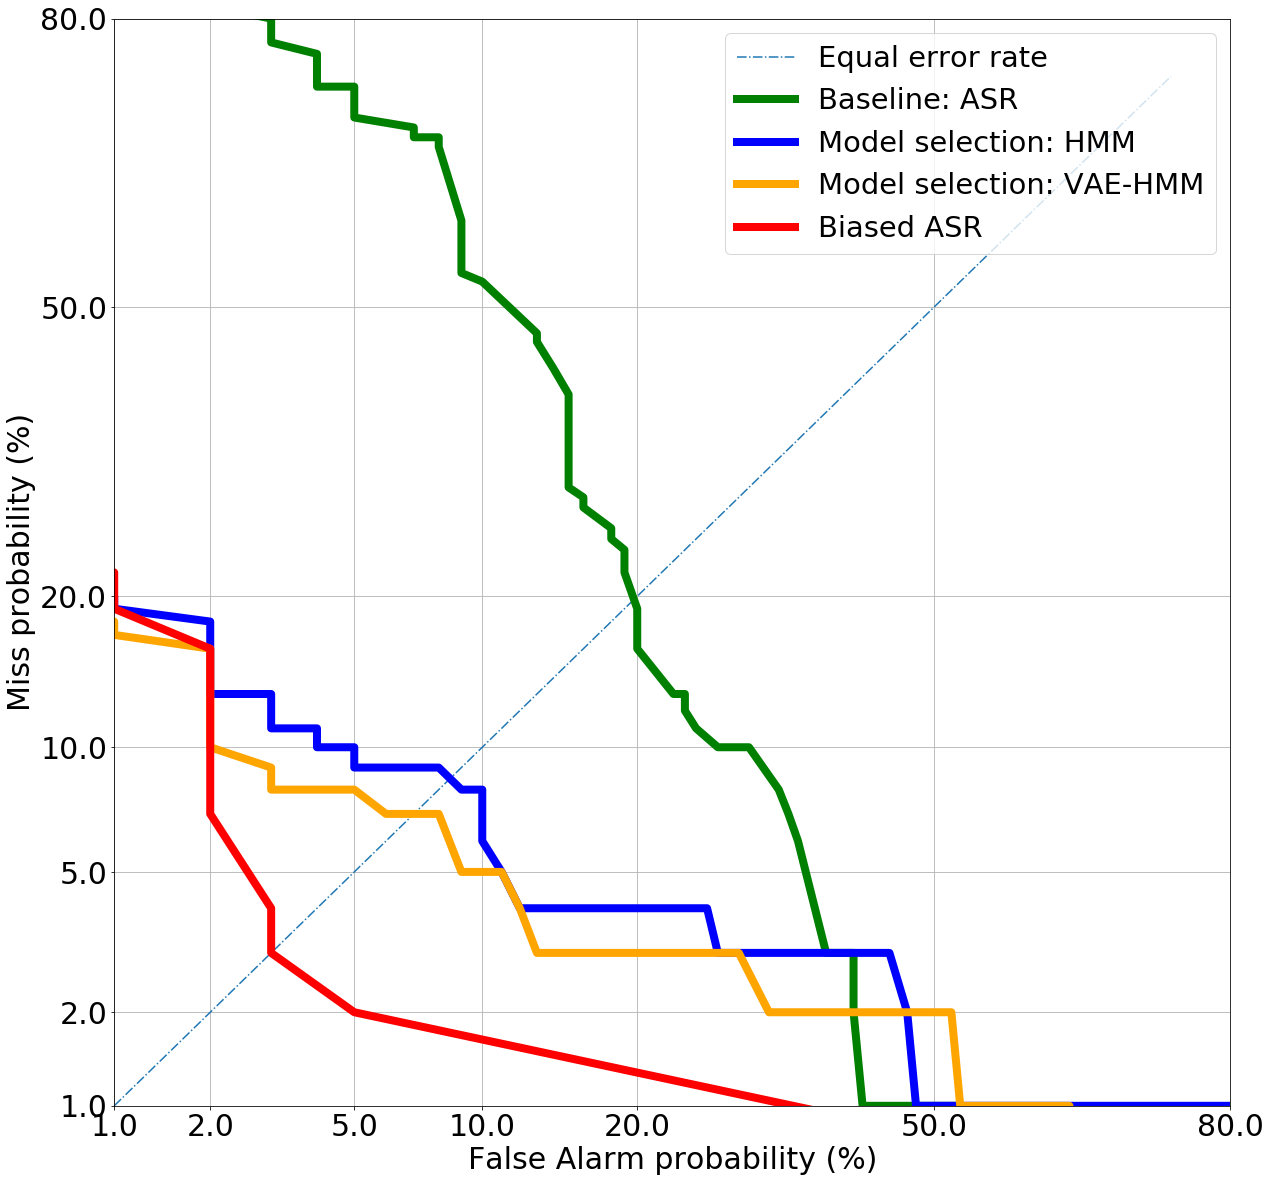

In [9]:

thres_hmm, fn_hmm, fp_hmm, _ = read_fn_fp('../wsj/comp_llhs/kaldi_lda/hmm_gmm/test_eval92_lda_corrupted/det_frame_llhs.txt')
thres_vae, fn_vae, fp_vae, _ = read_fn_fp('../wsj/comp_llhs/kaldi_lda/vae_hmm/test_eval92_lda_corrupted/det_frame_llhs.txt')
thres_per, fn_per, fp_per, _ = read_fn_fp('../wsj/comp_llhs/kaldi_lda/kaldi_wer_per_utt/det_per.txt')
thres_cleanup, fn_cleanup, fp_cleanup, _ = read_fn_fp('../wsj/comp_llhs/kaldi_lda/kaldi_biased_LM_wer_per_utt/det_per.txt')

x = np.arange(compute_probit(1e-2), compute_probit(.8))
y = x

hmm_equal = find_equal(fn_hmm, fp_hmm)
vae_equal = find_equal(fn_vae, fp_vae)
#per_equal = find_equal(fn_per, fp_per)
cleanup_equal = find_equal(fn_cleanup, fp_cleanup)

# Plot det
plt.figure(figsize=(20, 20))
plt.plot(x, y, '-.')
plt.plot(fp_per, fn_per, color='g', linewidth=8, linestyle='-')
plt.plot(fp_hmm, fn_hmm, color='b', linewidth=8, linestyle='-')
plt.plot(fp_vae, fn_vae, color='orange', linewidth=8, linestyle='-')
plt.plot(fp_cleanup, fn_cleanup, color='r', linewidth=8, linestyle='-')


plt.xlabel('False Alarm probability (%)', fontsize=30)
plt.ylabel('Miss probability (%)', fontsize=30)
plt.legend(['Equal error rate', 
            'Baseline: ASR', 
            'Model selection: HMM',
            'Model selection: VAE-HMM',
            'Biased ASR',], 
            loc='upper right',
            fontsize=29)


plt.xticks(create_ticks()[0], create_ticks()[1], fontsize=30)
plt.yticks(create_ticks()[0], create_ticks()[1], fontsize=30)
plt.xlim([compute_probit(1e-2), compute_probit(.8)])
plt.ylim([compute_probit(1e-2), compute_probit(.8)])

plt.grid()
plt.savefig('./joint_per_detection/pics/det_comparison_wsj_corrupted.png')
plt.show()

In [38]:
from scipy.stats import norm

In [273]:
1124823/100/3600

3.124508333333333

0.08695652173913043